In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2

In [ ]:
# ======= PATH ========
dataset_path = '/content/tomatoleaf/clean_tomato_dataset_td'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

save_dir = "/content/drive/MyDrive/train_tomato/InceptionV3-GradCAM"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# ======= DATA AUGMENTATION ========
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
image_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

Found 2240 images belonging to 8 classes.
Found 391 images belonging to 8 classes.


In [ ]:
# ======= MODEL ========
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ======= CALLBACKS ========
# Explanation: Updated paths for InceptionV3 weights and model.
checkpoint_path = os.path.join(save_dir, 'inceptionv3_best.weights.h5')
model_path = os.path.join(save_dir, 'inceptionv3_final.keras')

callbacks = [
    ModelCheckpoint(checkpoint_path, save_weights_only=True, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
]

In [ ]:
# ======= TRAINING PHASE 1: Train top layers ========
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.3172 - loss: 1.9866
Epoch 1: val_accuracy improved from -inf to 0.47570, saving model to /content/drive/MyDrive/train_tomato/InceptionV3-GradCAM/inceptionv3_best.weights.h5
70/70 ━━━━━━━━━━━━━━━━━━━━ 61s 627ms/step - accuracy: 0.3184 - loss: 1.9826 - val_accuracy: 0.4757 - val_loss: 1.4847 - learning_rate: 1.0000e-04
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.5751 - loss: 1.2538
Epoch 2: val_accuracy improved from 0.47570 to 0.62916, saving model to /content/drive/MyDrive/train_tomato/InceptionV3-GradCAM/inceptionv3_best.weights.h5
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 434ms/step - accuracy: 0.5751 - loss: 1.2534 - val_accuracy: 0.6292 - val_loss: 1.1512 - learning_rate: 1.0000e-04
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6638 - loss: 1.0061
Epoch 3: val_accuracy improved from 0.62916 to 0.70332, saving model to /content/drive/MyDrive/train_tomato/InceptionV3-GradCAM/inceptionv3_b

In [ ]:
# ======= TRAINING PHASE 2: Unfreeze and Fine-Tune ========
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

model.save(model_path)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4675 - loss: 1.5223
Epoch 1: val_accuracy improved from 0.77494 to 0.77749, saving model to /content/drive/MyDrive/train_tomato/InceptionV3-GradCAM/inceptionv3_best.weights.h5
70/70 ━━━━━━━━━━━━━━━━━━━━ 116s 636ms/step - accuracy: 0.4688 - loss: 1.5190 - val_accuracy: 0.7775 - val_loss: 0.6749 - learning_rate: 1.0000e-05
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7394 - loss: 0.8498
Epoch 2: val_accuracy improved from 0.77749 to 0.81330, saving model to /content/drive/MyDrive/train_tomato/InceptionV3-GradCAM/inceptionv3_best.weights.h5
70/70 ━━━━━━━━━━━━━━━━━━━━ 46s 618ms/step - accuracy: 0.7398 - loss: 0.8489 - val_accuracy: 0.8133 - val_loss: 0.6186 - learning_rate: 1.0000e-05
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8248 - loss: 0.5981
Epoch 3: val_accuracy improved from 0.81330 to 0.83120, saving model to /content/drive/MyDrive/train_tomato/InceptionV3-GradCAM/inception

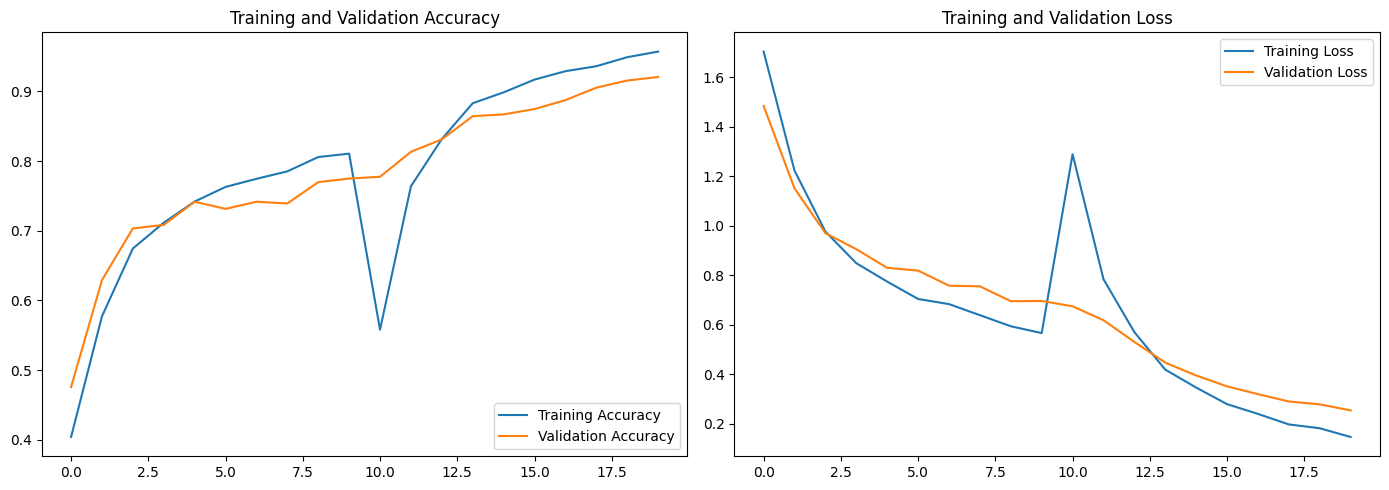

In [ ]:
# ======= Visualize Training ========
def plot_training_history(history1, history2=None):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history, fine_tune_history)